In [1]:
# Shallow ice flow model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

import firedrake 
import tqdm
from firedrake import sqrt, exp, Constant, Function

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


/Users/bkyanjo3/firedrake/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Text(0.5, 1.0, 'Mesh')

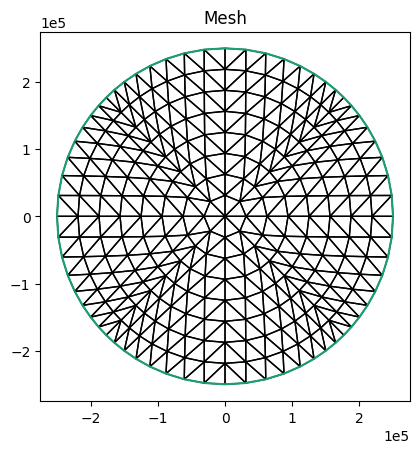

In [3]:
# Geometry
mesh = firedrake.UnitDiskMesh(3)
R = 250e3 # domain is a circle of 250 km wide
# R = 250
mesh.coordinates.dat.data[:] *= R

# Plateau elevation
b_base = Constant(400)
# b_base = Constant(0.4)

# Max Elevation
b_max = Constant(1400)
# b_max = Constant(1.4)

# Radius of the plateau interior
ro = 125e3
# ro = 125

# Radius of the ridge
Ro = Constant(200e3)
# Ro = Constant(200)
import icepack.plot

fig, axes = icepack.plot.subplots()
firedrake.triplot(mesh, axes=axes)
axes.set_title("Mesh")

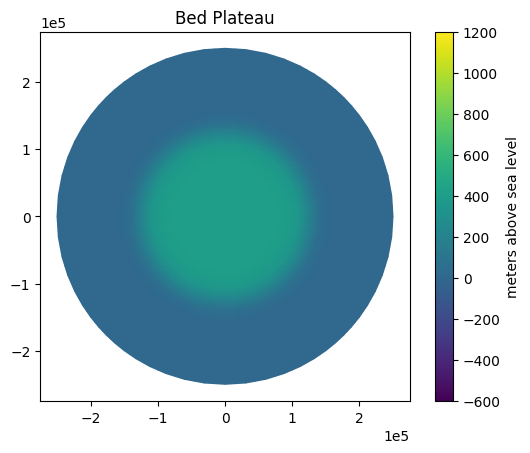

In [4]:
# input data: ice bed, surface, thickness, velocity, and accumulation rate
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2) 
V = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2)

x, y = firedrake.SpatialCoordinate(mesh)
r = sqrt(x**2 + y**2)

def tanh(z):
    return (exp(z) - exp(-z))/(exp(z) + exp(-z))

def theta(z):
    return (tanh(z) + 1)/2

def sech(z):
    return 2/(exp(z) + exp(-z))

# make a plateau on which the ice sheet sits
a = Constant(50e3)
eta = (sqrt(x**2 + y**2) - ro)/a

b_expr_plateau = b_base * (1 - theta(3*eta))
b = Function(Q).interpolate(b_expr_plateau)

fig,axes = icepack.plot.subplots()
kw = {"vmin": -600, "vmax":1200}
colors = firedrake.tripcolor(b, axes=axes, shading="gouraud", cmap="viridis", **kw)
axes.set_title("Bed Plateau")
fig.colorbar(colors, label="meters above sea level")


Text(0.5, 1.0, 'Bed Plateau and Ridge')

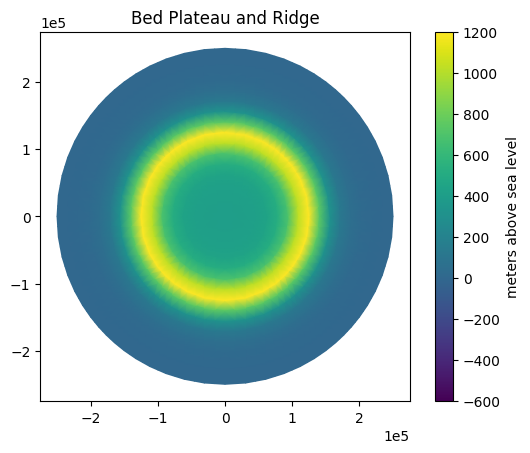

In [5]:
# Add a ridge that runs along the edge of the plateau
zta = (r- Ro)/a

b_expr_ridge = (b_max - b_base) * sech(3*eta)
b_expr = b_expr_plateau + b_expr_ridge
b = Function(Q).interpolate(b_expr)

fig, axes = icepack.plot.subplots()
contors = firedrake.tripcolor(b, axes=axes, shading="gouraud", cmap="viridis", **kw)
fig.colorbar(contors, label="meters above sea level")
axes.set_title("Bed Plateau and Ridge")

Text(0.5, 1.0, 'Bed Plateau, \n Ridge, and Valleys')

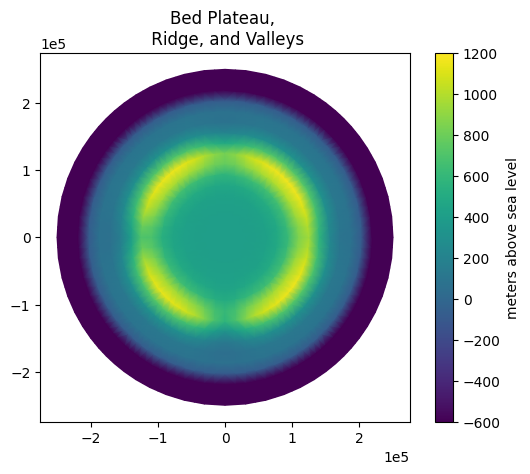

In [6]:
# cut valleys into the ridge to get bed topography
rho1 = Constant(1/4)
mu1 = 1- rho1*theta(3 * (x - ro / 4) / a) * sech(2 * y / a)

rho2 = Constant(3/8)
mu2 = 1 - rho2 * theta(3 * (y - ro / 4) / a) * sech(2 * x / a)

rho3 = Constant(1/2)
mu3 = 1 - rho3 * theta(3 * (-x + ro / 4) / a) * sech(2 * y / a)

rho4 = Constant(5/8)
mu4 = 1 - rho4 * theta(3 * (-y + ro / 4) / a) * sech(2 * x / a)

mu = mu1 * mu2 * mu3 * mu4
S = 480/(1-Ro/R)

b_expr_valleys = (b_max - b_base) * sech(3 * eta) * mu - theta(5 * zta) * S*zta
b_expr = b_expr_plateau + b_expr_valleys
b = Function(Q).interpolate(b_expr)

fig, axes = icepack.plot.subplots()
contours = firedrake.tripcolor(b, axes=axes, **kw)
fig.colorbar(contours, label="meters above sea level")
axes.set_title("Bed Plateau, \n Ridge, and Valleys")

w₁₉


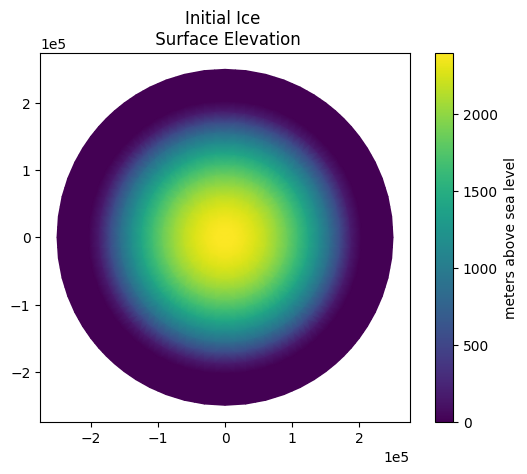

In [7]:
# Now we will put an Initial ice sheet on this bed

from firedrake import max_value

# surface elevation
max_radius = 195e3
# max_radius = 195
dome_height = 2.4e3
# dome_height = 2.4

dome = dome_height*max_value(1-(x**2 + y**2)/(max_radius**2), 0)
s0 = Function(Q).interpolate(dome)

# thickness
h0 = Function(Q).interpolate(max_value(s0 - b, 0))
print(h0)

fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(s0, axes=axes)
fig.colorbar(colors, label="meters above sea level")
axes.set_title("Initial Ice \n Surface Elevation");

In [ ]:
fig, axes = icepack.plot.subplots()
colors_b = firedrake.tripcolor(b, axes=axes)
levels = np.linspace(100, 2300, 13)
contours_h = firedrake.tricontour(h0, levels, axes=axes, cmap="Blues")
fig.colorbar(colors_b, label="meters")
axes.set_title("Initial Ice Thickness Contours \n overlain on Bed Surface");

## Modeling

In [ ]:
import icepack
model = icepack.models.ShallowIce()

# solve the problem; intializa the flow solver
solver = icepack.solvers.FlowSolver(model) # initialize the flow solver with any argument that never changes throughout the simulation 

# Fluidity factor A
T = Constant(273.15 -5)
A = icepack.rate_factor(T)

# compute the velocity field- call the diagnostic solver
u0 = firedrake.Function(V) # pass in an empty function since we have no initial velocity field
h = h0.copy(deepcopy=True)
u = solver.diagnostic_solve(
    velocity=u0,
    thickness=h,
    surface=s0,
    fluidity=A,
)
# Note: this solver takes in the intial velocity of the ice field, thickness, surface, and fluidity factor as arguments and returns the velocity field

# save the initial velocity field
u0 = u.copy(deepcopy=True)

# plot the velocity field
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(u, axes=axes)
fig.colorbar(colors, label="meters / year")
axes.set_title("Initial Ice Velocity");


In [10]:
# To evolve the ice sheet, we will need to choose a mass balance field

from firedrake import min_value
def mass_balance(s,max_a=0.5,da_ds=0.5/1000,ela=300.9):
    return min_value((s-ela)*da_ds, max_a)

ela = 300
max_a = 0 
da_ds = 0

a = mass_balance(s0,ela=ela, max_a=max_a, da_ds=da_ds)


In [11]:

# # General simulation without any checkpoints ==========
# # TO project the state of the ice sheet in time we will call the prognostic solver routine to update the ice thickness and then call the diagnostic solver to update the velocity field given current thickness.

# # the following code runs the model forward 500 years with a 10 year time step until the ice sheet reaches steady state.
# dt = 10
# num_years = 500
# num_timesteps = int(num_years/dt)

# dh_max = np.zeros(num_timesteps)*np.nan
# a = Function(Q)

# for step in tqdm.trange(num_timesteps):
#     h_old = h.copy(deepcopy=True)
#     h = solver.prognostic_solve(
#         dt,
#         thickness=h,
#         accumulation=a,
#         velocity=u,
#     )

#     h.interpolate(max_value(h, 0))
#     s = Function(Q).interpolate(b + h)
#     u = solver.diagnostic_solve(
#         velocity=u,
#         thickness=h,
#         surface=s,
#         fluidity=A,
#     )

#     a.interpolate(mass_balance(s,ela=ela, max_a=max_a, da_ds=da_ds))

#     dh = Function(Q).interpolate(h - h_old)
#     dh_max[step] = dh.dat.data_ro.max()

## Apply Data Assmilation to Icepack

In [12]:
def shallowIce_icepack(dt, h, u, b, a, ela, max_a, da_ds):

    # h and u are arrays convert then to firedrake functions
    # if isinstance(h, np.ndarray):
    #     # Assuming `h` is a 1D array, project it into the function space `Q`
    #     h_function = Function(Q)
    #     h_function.dat.data[:] = h[:]  # Assign NumPy array values to the Function data
    #     h = h_function

    # if isinstance(u, np.ndarray):
    #     u_function = Function(V)
    #     u_function.dat.data[:,:] = u[:,:]
    #     u = u_function

    h_old = h.copy(deepcopy=True)
    h = solver.prognostic_solve(
        dt,
        thickness=h,
        accumulation=a,
        velocity=u,
    )

    h.interpolate(max_value(h, 0))
    s = Function(Q).interpolate(b + h)
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        surface=s,
        fluidity=A,
    )

    a.interpolate(mass_balance(s,ela=ela, max_a=max_a, da_ds=da_ds))

    dh = Function(Q).interpolate(h - h_old)
    dh_max = dh.dat.data_ro.max()

    # convert the firedrake functions to arrays
    # h = h.dat.data_ro
    # u = u.dat.data_ro
    # s = s.dat.data_ro
    # dh = dh.dat.data_ro

    return h, u, a, dh_max


In [13]:
# Observation operators
# def Obs(u):
#     w = u
#     return w

# def JObs(u):
#     n = len(u)
#     D = np.eye(n)
#     return D

def Obs(huxg_virtual_obs, m_obs):
    # Determine the size of the observation vector
    n = huxg_virtual_obs.shape[0]
    m = m_obs

    # Initialize the H matrix with zeros
    H = np.zeros((m * 2 + 1, n))

    # Calculate the distance between measurements
    di = int((n - 2) / (2 * m))  # Python uses int for integer division

    # Fill in the H matrix
    for i in range(m):
        H[i, i * di] = 1
        H[m + i, int((n - 2) / 2) + i * di] = 1


    # Final element of H matrix
    H[m * 2, n - 2] = 1  # Adjust for 0-based indexing

    # Perform matrix multiplication
    z = H @ huxg_virtual_obs  # '@' operator for matrix multiplication in Python
    return z

# Jacobian of the observation operator ----------------------
def JObs(n_model, m_obs):
    # Initialize the H matrix with zeros
    n = n_model
    m = m_obs
    H = np.zeros((m * 2 + 1, n))

    # Calculate the distance between measurements
    di = int((n - 2) / (2 * m))  # Convert distance to an integer

    # Fill in the H matrix
    for i in range(m):  # Python uses 0-based indexing
        H[i, i * di] = 1  # Adjust for 0-based indexing
        H[m + i, int((n - 2) / 2) + i * di] = 1  # Adjust for 0-based indexing

    # Final element of H matrix
    H[m * 2, n - 2] = 1  # Adjust for 0-based indexing

    return H

In [14]:
# --- Forecast step ---
def forecast_step(ensemble, dt, Nens, ndim, a, *args):
    """ensemble: packs the state variables:h,u,v of the ensemble members
                 where h is thickness, u and v are the x and y components 
                 of the velocity field
        dt: time step
        Nens: number of ensemble members
        ndim: number of dimensions of the state variables
        a: accumulation rate
        args: other arguments: b, ela, max_a, da_ds

    Returns: ensemble: updated ensemble members
             a: updated accumulation rate
    """
    # unpack the arguments
    b     = args[0]
    ela   = args[1]
    max_a = args[2]
    da_ds = args[3]
    
    # iterate over the ensemble members
    for ens in range(Nens):
        h_vec = ensemble[:ndim, ens]
        u_vec = ensemble[ndim:2*ndim, ens]
        v_vec = ensemble[2*ndim:, ens]

        # create firedrake functions from the ensemble members
        h = Function(Q)
        h.dat.data[:] = h_vec[:]

        u = Function(V)
        u.dat.data[:,0] = u_vec[:]
        u.dat.data[:,1] = v_vec[:]

        # call the shallowIce_icepack function to update the state variables
        h, u, a, dh_max = shallowIce_icepack(dt, h, u, b, a, ela, max_a, da_ds)

        # update the ensemble members with the new state variables and noise 
        ensemble[:ndim, ens]        = h.dat.data_ro      + np.random.normal(0, 0.1, h.dat.data_ro.shape)
        ensemble[ndim:2*ndim, ens]  = u.dat.data_ro[:,0] + np.random.normal(0, 0.1, u.dat.data_ro[:,0].shape)
        ensemble[2*ndim:, ens]      = u.dat.data_ro[:,1] + np.random.normal(0, 0.1, u.dat.data_ro[:,1].shape)

    return ensemble, a


In [15]:
# Ensemble Kalman Filters
# EnKF analysis step function ------------------------------
def EnKF_analysis_step(huxg_ens, huxg_obs, ObsFun, JObsFun, Cov_obs, Cov_model, params, taper=None):
    """
    Analysis step of the Ensemble Kalman Filter (EnKF).
    
    huxg_ens: ndarray (n x N) - The ensemble matrix of model states (n is state size, N is ensemble size).
    huxg_obs: ndarray (m,) - The observation vector (m is measurement size).
    ObsFun: Function - Observation function.
    JObsFun: Function - Jacobian of the observation function.
    Cov_obs: ndarray (m x m) - Observation covariance matrix.
    Cov_model: ndarray (n x n) - Model covariance matrix.
    params: dict - Dictionary containing parameters like "m_obs".
    taper: ndarray (n x n) - Covariance taper matrix.
    
    Returns:
    analysis_ens: ndarray (n x N) - The updated ensemble after analysis.
    analysis_cov: ndarray (n x n) - The updated covariance after analysis.
    """
    n, N = huxg_ens.shape  # n is the state size, N is the ensemble size
    m = huxg_obs.shape[0]  # Measurement size (m)

    # Compute the ensemble mean
    huxg_ens_mean = np.mean(huxg_ens, axis=1, keepdims=True)  # mean of model forecast ensemble
    
    # Compute the Jacobian of the observation operator
    Jobs = JObsFun(n, params["m_obs"])  # Jacobian of the observation operator
    
    # Compute the Kalman Gain
    KalGain = Cov_model @ Jobs.T @ np.linalg.inv(Jobs @ Cov_model @ Jobs.T + Cov_obs)

    # Initialize variables
    obs_virtual = np.zeros((m, N))  # Virtual observations for the ensemble
    analysis_ens = np.zeros_like(huxg_ens)  # Analysis ensemble

    # Perform the analysis for each ensemble member
    for i in range(N):
        # Generate virtual observations using multivariate normal distribution
        obs_virtual[:, i] = huxg_obs + multivariate_normal.rvs(mean=np.zeros(m), cov=Cov_obs)

        # Update the ensemble member with the Kalman gain
        analysis_ens[:, i] = huxg_ens[:, i] + KalGain @ (obs_virtual[:, i] - ObsFun(huxg_ens[:, i], params["m_obs"]))
    
    # Compute the mean of the analysis ensemble
    analysis_ens_mean = np.mean(analysis_ens, axis=1, keepdims=True)
    
    # Compute the analysis error covariance
    analysis_cov = (1 / (N - 1)) * (analysis_ens - analysis_ens_mean) @ (analysis_ens - analysis_ens_mean).T
    # analysis_cov = analysis_cov * taper  # Apply covariance tapering
    
    return analysis_ens, analysis_cov

In [ ]:
# time integration
s = Function(Q).interpolate(b + h.interpolate(max_value(h, 0)))
h_old = h.copy(deepcopy=True)
dh = Function(Q).interpolate(h - h_old)

# Initial conditions
h0 = h.copy(deepcopy=True)
u0 = u.copy(deepcopy=True)

print(h0.dat.data_ro.size)

In [17]:
# Ensemble parameters
dt = 10
tm = 500
nt = int(tm/dt)
t = np.linspace(0,tm,nt+1)

# Dimension of model state
state_variables = 3
hdim = h0.dat.data_ro.size
nd = state_variables*hdim

#  initial conditions
np.random.seed(seed=1)
sig_model   = 1e-1
sig_obs     = 1e-2
sig_Q       = 1e-2

Cov_model = (sig_model**2)*np.eye(nd)

Q_err = (sig_Q**2)*np.eye(nd)

dt_m = 15 # time interval between observations
tm_m = 150 # maximum time of observations
nt_m = int(tm_m/dt_m) # number of observations instants
ind_m = (np.linspace(int(dt_m/dt),int(tm_m/dt),nt_m)).astype(int) # indexes of observation instants
t_m = t[ind_m] # time instants of observations

sig_b= 0.1

# B = sig_b**2*np.eye(nd)
ub = np.zeros([nd,nt+1])
# ub[:,0] = u0b
ua = np.zeros([nd,nt+1])
# ua[:,0] = u0b
n = nd #state dimension
m = nd #measurement dimension
# ensemble size
N = 10

# no of observations
n_obs = 10 
params = {"m_obs": n_obs}

ts_obs = np.arange(10,140+1,10)*tm
idx_obs = np.nonzero(np.isin(t, ts_obs))[0]

In [ ]:
# True simulation
statevec_true = np.zeros([nd,nt+1])
# hTrue[:,0] = h0.dat.data_ro
statevec_true[:hdim,0] = h0.dat.data_ro
statevec_true[hdim:2*hdim,0] = u0.dat.data_ro[:,0]
statevec_true[2*hdim:,0] = u0.dat.data_ro[:,1]

# km = 0
# wh = np.zeros([nd,nt_m])
# uTrue = u0.copy(deepcopy=True)
dh_max_True = np.zeros(nt)*np.nan
a = Function(Q)
for step in tqdm.trange(nt):
    h, u , a, dh_max_True[step] = shallowIce_icepack(dt, h, u, b, a, ela, \
                                                        max_a, da_ds)
    # hTrue[:,step+1] = h.dat.data_ro
    statevec_true[:hdim,step+1] = h.dat.data_ro
    statevec_true[hdim:2*hdim,step+1] = u.dat.data_ro[:,0]
    statevec_true[2*hdim:,step+1] = u.dat.data_ro[:,1]
    # if (km<nt_m) and (step+1 == ind_m[km]):
    #     # wu[:,:,km] = Obs(uval[:,:,step+1]) + np.random.normal(0,sig_m,[nd,2])
    #     wh[:,km] = Obs(hTrue[:,step+1], params["m_obs"]) + np.random.normal(0,sig_m,nd)
    #     # ws[:,km] = Obs(sval[:,step+1]) + np.random.normal(0,sig_m,nd)
    #     # wdh[:,km] = Obs(dhval[:,step+1]) + np.random.normal(0,sig_m,nd)
    #     km = km + 1

# plt.plot(statevec_true)
# plt.ylim(-500,3000)

In [ ]:
# --- plot the true state variables ---
fig, axes = icepack.plot.subplots()
step = 10
htrue = Function(Q)
htrue.dat.data[:] = statevec_true[:hdim,step]
colors = firedrake.tripcolor(htrue, axes=axes)
fig.colorbar(colors, label="meters above sea level")
axes.set_title("Ice Thickness at time step: {}".format(step))

# plot an evolving solution with time on one plot (more like a movie)
# for step in tqdm.trange(nt):
#     htrue.dat.data[:] = statevec_true[:hdim,step]
#     colors = firedrake.tripcolor(htrue, axes=axes)
#     fig.colorbar(colors, label="meters above sea level")
#     axes.set_title("Ice Thickness at time step: {}".format(step))
#     plt.pause(0.1)


In [ ]:
step = 0
plt.plot(statevec_true[:hdim,step])

In [21]:
# Intialize ensemble
statevec_bg = np.zeros((nd,nt+1))
statevec_ens_mean = np.zeros((nd,nt+1))
statevec_ens = np.zeros((nd,N))
statevec_ens_full = np.zeros((nd,N,nt+1))

# statevec_bg[:,0] = h0.dat.data_ro
statevec_bg[:hdim,0] = h0.dat.data_ro
statevec_bg[hdim:2*hdim,0] = u0.dat.data_ro[:,0]
statevec_bg[2*hdim:,0] = u0.dat.data_ro[:,1]

# statevec_ens_mean[:,0] = h0.dat.data_ro
statevec_ens_mean[:hdim,0] = h0.dat.data_ro
statevec_ens_mean[hdim:2*hdim,0] = u0.dat.data_ro[:,0]
statevec_ens_mean[2*hdim:,0] = u0.dat.data_ro[:,1]

# Intialize ensemble thickness and velocity
h_ens = np.array([h0.dat.data_ro for _ in range(N)])
u_ens = np.array([u0.dat.data_ro[:,0] for _ in range(N)])
v_ens = np.array([u0.dat.data_ro[:,1] for _ in range(N)])

for i in range(N):
    perturbed_state = multivariate_normal.rvs(mean=np.zeros(nd-1), cov=Cov_model[:-1,:-1])

    # statevec_ens[:-1,i] = h0.dat.data_ro[:-1] + perturbed_state
    statevec_ens[:hdim-1,i]         = h0.dat.data_ro[:-1] + perturbed_state[:hdim-1]
    statevec_ens[hdim:2*hdim-1,i]   = u0.dat.data_ro[:-1,0] + perturbed_state[hdim:2*hdim-1]
    statevec_ens[2*hdim:nd-1,i]         = u0.dat.data_ro[:-1,1] + perturbed_state[2*hdim:nd-1]

    # statevec_ens[-1,i] = h0.dat.data_ro[-1]
    statevec_ens[hdim-1,i]   = h0.dat.data_ro[-1]
    statevec_ens[2*hdim-1,i] = u0.dat.data_ro[-1,0]
    statevec_ens[-1,i]       = u0.dat.data_ro[-1,1]

statevec_ens_full[:,:,0] = statevec_ens
# statevec_ens_full


In [ ]:
# --- Run the model with the EnKF ---
a = Function(Q)
for k in tqdm.trange(nt):
    # Forecast step
    statevec_ens, a = forecast_step(statevec_ens, dt, N, hdim, a, b, ela, max_a, da_ds)

    # Compute the ensemble mean
    statevec_ens_mean[:,k+1] = np.mean(statevec_ens, axis=1)

    # Compute the model covariance
    diff = statevec_ens - np.tile(statevec_ens_mean[:,k+1].reshape(-1,1),N)
    Cov_model = 1/(N-1) * diff @ diff.T

    # Analysis step
    if t[k+1] in ts_obs:
        idx_obs = np.where(t[k+1] == ts_obs)[0]

        Cov_obs = sig_obs**2 * np.eye(2*params["m_obs"]+1)

        hu_obs = Obs(statevec_true[:,idx_obs], params["m_obs"])
        hu_obs = hu_obs.ravel()
        # w = statevec_true[:,k+1] + np.random.normal(0,sig_obs,nd)
        # h_obs = h_obs + np.random.normal(0,sig_obs,nd)

        # Compute the analysis ensemble
        statevec_ens, Cov_model = EnKF_analysis_step(statevec_ens, hu_obs, Obs, JObs, Cov_obs, Cov_model, params)

        statevec_ens_mean[:,k+1] = np.mean(statevec_ens, axis=1)

    # Save the ensemble
    statevec_ens_full[:,:,k+1] = statevec_ens

In [ ]:
# --- Plot the results with assimilation ---
# fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

hu_obs = Obs(statevec_true, params["m_obs"])

plt.plot(statevec_true[:,0], label="True")

In [ ]:
plt.plot(statevec_true[:hdim,step])